In [24]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [25]:
# Load the data
data = pd.read_csv('h234.csv')

# Drop any rows with missing values
data = data.dropna()

# Separate features (X) and target variable (y)
X = data.drop(columns=['Out_of_Pocket_Cost'])
y = data['Out_of_Pocket_Cost']

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100),
}

# Define tolerance for custom accuracy
tolerance = 0.1  # 10% tolerance

# Function to calculate custom accuracy
def custom_accuracy(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) / y_true < tolerance) * 100

# Initialize dictionary to store results
model_scores = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    custom_acc = custom_accuracy(y_test, y_pred, tolerance)

    model_scores[model_name] = {"RMSE": rmse, "MAE": mae, "Custom Accuracy (10% tolerance)": custom_acc}
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, Custom Accuracy (10% tolerance): {custom_acc:.2f}%")

RandomForest - RMSE: 2384.70, MAE: 908.37, Custom Accuracy (10% tolerance): 5.41%
XGBoost - RMSE: 3313.72, MAE: 1036.94, Custom Accuracy (10% tolerance): 2.25%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 46
[LightGBM] [Info] Start training from score 853.390079
LightGBM - RMSE: 1462.92, MAE: 891.65, Custom Accuracy (10% tolerance): 3.60%



Model Performance Comparison:
                      RMSE          MAE  Custom Accuracy (10% tolerance)
RandomForest  2384.699223   908.368378                         5.405405
XGBoost       3313.715499  1036.941190                         2.252252
LightGBM      1462.917987   891.647034                         3.603604


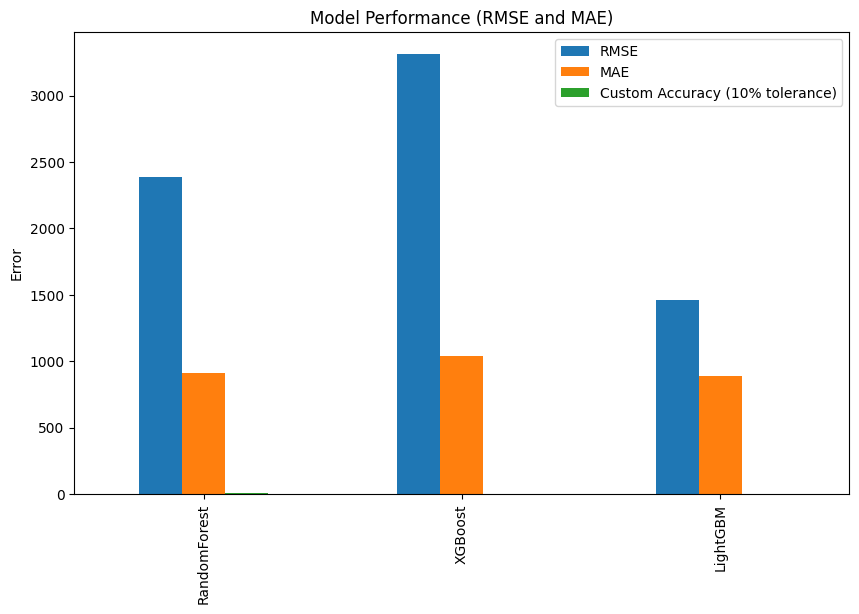

Best model (LightGBM) saved as 'LightGBM_model.pkl'.


In [27]:
# Display model performance comparison
model_performance = pd.DataFrame(model_scores).T
print("\nModel Performance Comparison:\n", model_performance)

# Optional: Plot model performance
model_performance.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance (RMSE and MAE)")
plt.ylabel("Error")
plt.show()

# Save the best model based on RMSE
best_model_name = model_performance['RMSE'].idxmin()
best_model = models[best_model_name]
pickle.dump(best_model, open(f'{best_model_name}_model.pkl', 'wb'))
print(f"Best model ({best_model_name}) saved as '{best_model_name}_model.pkl'.")

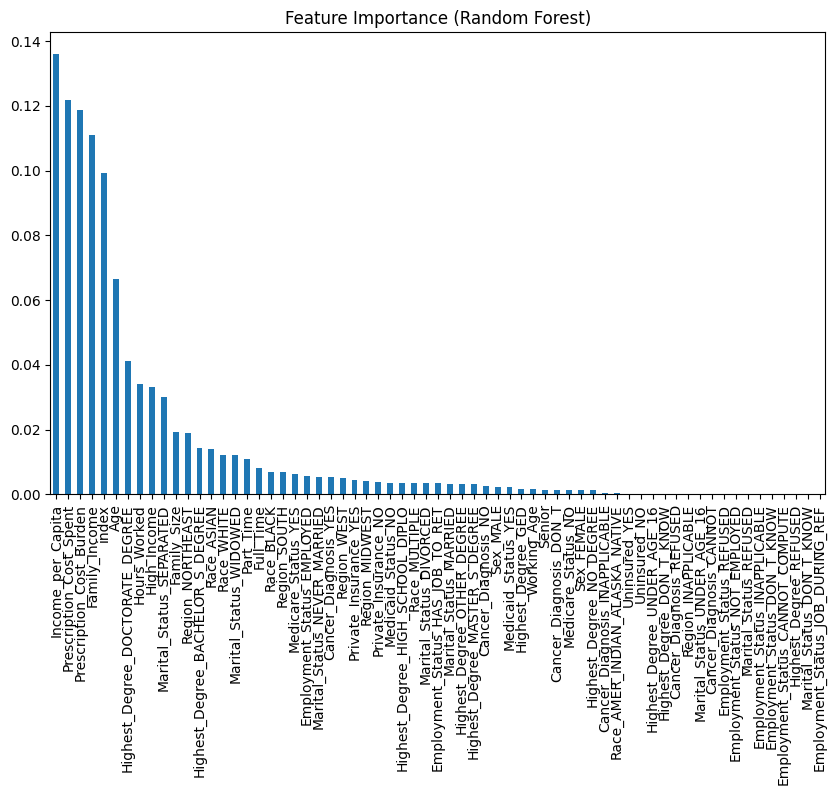

In [28]:
# Check feature importance using Random Forest
feature_importances = models["RandomForest"].feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()



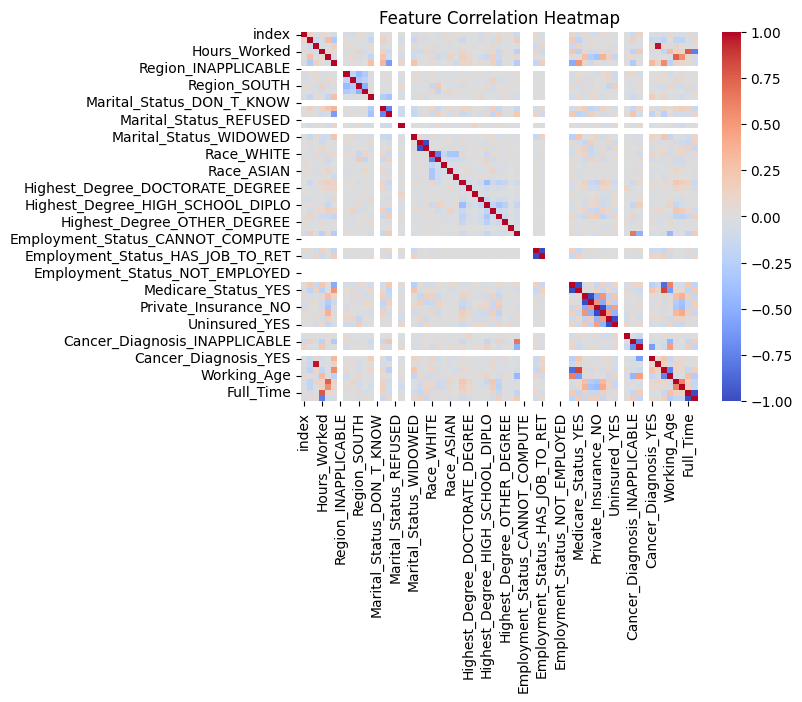

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Check correlations
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()



In [30]:
X['Income_per_Hour'] = X['Family_Income'] / (X['Hours_Worked'] + 1)  # Avoid division by zero
X['Cost_per_Family'] = X['Prescription_Cost_Spent'] / (X['Family_Size'] + 1)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Use X_poly instead of X for training and testing

X['Family_Income_log'] = np.log1p(X['Family_Income'])
X['Prescription_Cost_Spent_log'] = np.log1p(X['Prescription_Cost_Spent'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets *before* applying transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values using SimpleImputer before applying PolynomialFeatures
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # You can choose a different strategy if needed

# Fit and transform on training data, then transform test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply PolynomialFeatures (or other transformations) to training and test sets separately
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_imputed)
X_test_poly = poly.transform(X_test_imputed)  # Use transform, not fit_transform, on test data


# Convert the transformed arrays back to DataFrames if needed (for visualization, etc.)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_train.index)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_test.index)

# Ensure all column names are strings (if needed)
X_train_poly.columns = X_train_poly.columns.astype(str)
X_test_poly.columns = X_test_poly.columns.astype(str)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and fit GridSearch
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_poly, y_train)

# Best parameters
print("Best Parameters for RandomForest:", grid_search.best_params_)

# Re-evaluate with best model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))